In [16]:
%matplotlib inline
import warnings
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", UserWarning)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, BaggingClassifier
from sklearn.model_selection import train_test_split,ValidationCurveDisplay
import sklearn.datasets, sklearn.tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_samples, silhouette_score, fowlkes_mallows_score
from sklearn.cluster import KMeans,AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import MDS,TSNE 
sns.set(style='white',context='talk',palette='Set1')


[The Heart Failure Prediction](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction/data) Dataset on Kaggle comprises medical data associated with patients who have encountered heart failure. It includes various clinical, demographic, and physiological features aimed at predicting the likelihood of heart failure based on individual characteristics. Researchers and data scientists utilize this dataset to develop predictive models for identifying individuals at higher risk of heart failure, providing insights into underlying factors contributing to the condition.

The dataset can be found in the following path "../data/heart.csv".
Read the dataset into a pandas dataframe.

In [2]:
data = pd.read_csv("../data/heart.csv")
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


Perform basic exploratory data analysis on the dataset (e.g., variable distributions and correlations). Include at least 3 different figures which you find intresting.

In [3]:
# Write your code here. Add additional cells if necessary.

Before applying a machine-learning model, make sure all categorical are converted to bianry/boolean columns using one-hot-encoding, as we did in class.

In [4]:
data = pd.get_dummies(data ,prefix=['Sex','ChestPainType','RestingECG','ExerciseAngina','ST_Slope'], columns = ['Sex','ChestPainType','RestingECG','ExerciseAngina','ST_Slope'], drop_first=True)
data.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,True,True,False,False,True,False,False,False,True
1,49,160,180,0,156,1.0,1,False,False,True,False,True,False,False,True,False
2,37,130,283,0,98,0.0,0,True,True,False,False,False,True,False,False,True
3,48,138,214,0,108,1.5,1,False,False,False,False,True,False,True,True,False
4,54,150,195,0,122,0.0,0,True,False,True,False,True,False,False,False,True


Let's start with some unsupervised learning for visualiztion and gaining insights about the data. Apply PCA on the dataset features (i.e., do not include the 'HeartDisease' column in the analysis ). Don't forget ot scale the data appropriately as we did in class.

In [21]:
scaler = StandardScaler()
scaled_dataset = scaler.fit_transform(data.drop(columns=['HeartDisease']))

In [22]:
pca = PCA()
PCs = pca.fit_transform(scaled_dataset)

What proportion of the variance is captured by the top two principal components?

In [29]:
variance_ratio = pca.explained_variance_ratio_[:2]
proportion_variance = sum(variance_ratio)

print("Proportion of variance explained by the top two principal components:", proportion_variance)

Proportion of variance explained by the top two principal components: 0.335953394244012


Plot the points from the dataframe in a 2D space using the two most significant principal components. Assign colors to the points based on their corresponding labels in the HeartDisease column. Can you observe clear separation between the two labels?

In [50]:
df_pca = pd.DataFrame(data=PCs, columns=[f'PC{i+1}' for i in range(PCs.shape[1])])
df_pca["HeartDisease"] = data["HeartDisease"]

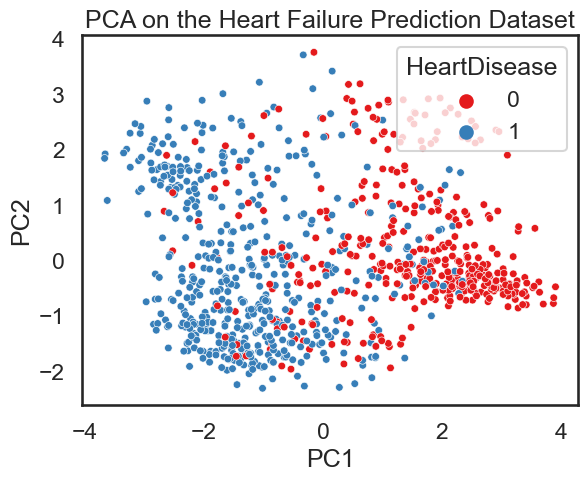

In [56]:
sns.scatterplot(data = df_pca, x="PC1", y="PC2", hue="HeartDisease", s= 30)
plt.title('PCA on the Heart Failure Prediction Dataset');

Apply a non-linear dimensionality reduction algotrithm to 2D, and generate a corresponding plot. Is the separation between classes better?

In [44]:
X_transformed_TSNE = TSNE(n_components=2).fit_transform(data.drop(columns=['HeartDisease']))

In [53]:
df_TSNE = pd.DataFrame(data=X_transformed_TSNE, columns=['V1','V2'])
df_TSNE["HeartDisease"] = data["HeartDisease"]

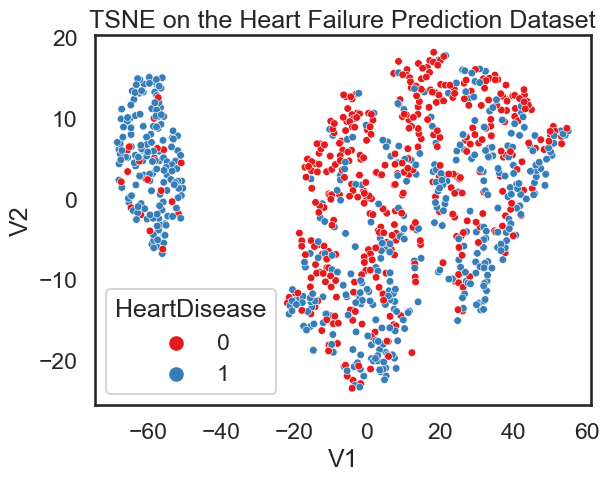

In [55]:
sns.scatterplot(data = df_TSNE, x="V1", y="V2", hue="HeartDisease", s= 30)
plt.title('TSNE on the Heart Failure Prediction Dataset');

Divide the dataset to training and test sets, keeping 30% of the data in test set.

In [5]:
X = data.drop(columns=['HeartDisease']) # Features
y = data['HeartDisease'] # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10) # 70% training and 30% test

Fit the logistic regression model on the training data and estimate the performance on the test data. Estimate accuracy, precision and recall on the test data using the `confusion_matrix` function we used in class . Explain in your words what is the interpretation of the accuracy, precision and recall you obtained.

In [6]:
from sklearn.linear_model import LogisticRegression
lg = LogisticRegression(max_iter=1000)
lg.fit(X_train,y_train)

LogisticRegression(max_iter=1000)

In [7]:
y_pred_lg = lg.predict(X_test) #prediction using a threshold of P > 0.5
tn_lg, fp_lg, fn_lg, tp_lg = confusion_matrix(y_test, y_pred_lg).ravel()
accuracy_lg = (y_pred_lg==y_test).mean()
precision_lg = tp_lg/(tp_lg+fp_lg)
recall_lg = tp_lg/(tp_lg+fn_lg)
print(f'Accuracy = {round(accuracy_lg,2)}, Precision = {round(precision_lg ,2)}, Recall = {round(recall_lg,2)} ')

Accuracy = 0.85, Precision = 0.86, Recall = 0.86 


Create a pandas DataFrame containing the column names alongside their logistic regression coefficients. Provide a suitable interpretation of the coefficients for 'Age' and 'Sex'.

In [8]:
coef_df = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': lg.coef_[0]})
coef_df

,Feature,Coefficient
0,Age,0.017366
1,RestingBP,0.002594
2,Cholesterol,-0.002566
3,FastingBS,0.930896
4,MaxHR,-0.006887
5,Oldpeak,0.396894
6,Sex_M,1.601547
7,ChestPainType_ATA,-1.410916
8,ChestPainType_NAP,-1.719325
9,ChestPainType_TA,-1.061692


Now, utilize the random forest classification model with its default hyperparameters. Calculate the accuracy, precision, and recall on the test set. You can achieve this by employing the `accuracy_score`, `precision_score`, and `recall_score` functions available in the `sklearn.metrics` module.

In [10]:
rf = RandomForestClassifier()

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
print("Accuracy:", round(accuracy_score(y_test, y_pred_rf),2),"Precision:", round(precision_score(y_test, y_pred_rf),2),"Recall:", round(recall_score(y_test, y_pred_rf),2))

Accuracy: 0.83 Precision: 0.84 Recall: 0.86


Which features are the most important? Generate a bar plot displaying the feature importance.

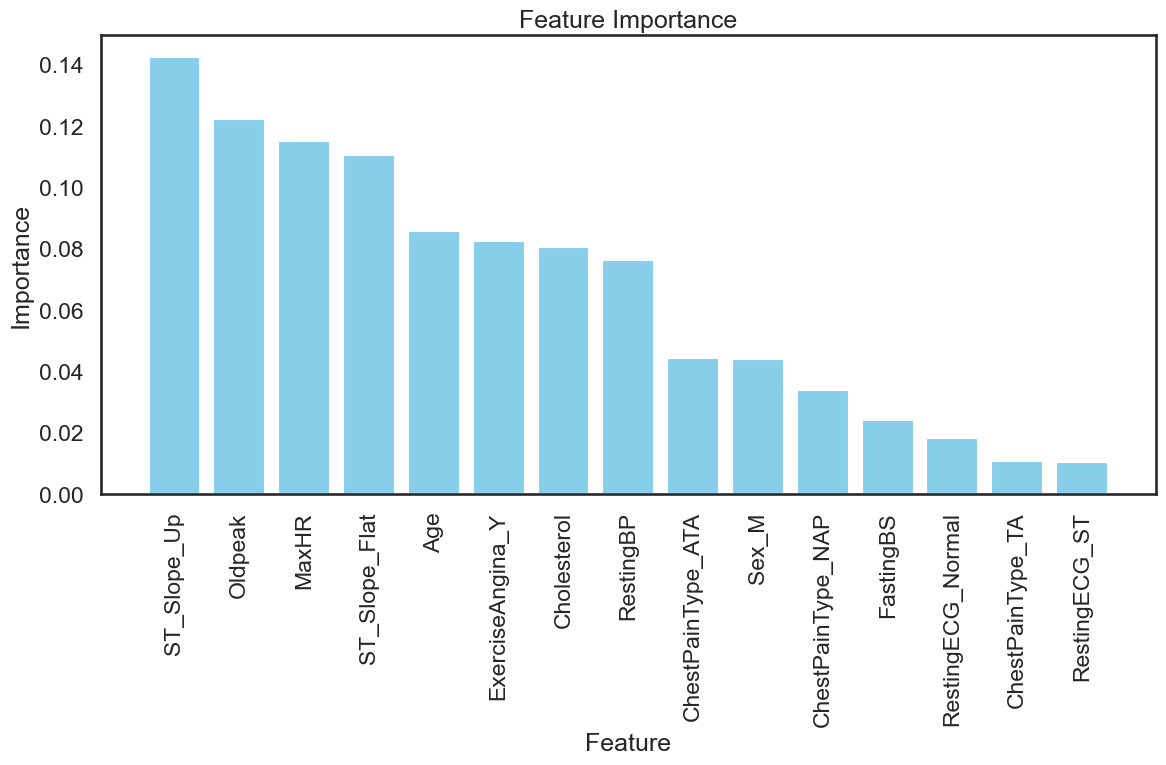

In [11]:
# Get feature importances
importances = rf.feature_importances_

# Create a DataFrame with feature names and importances
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
plt.bar(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.title('Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Try to improve the current random forest classifier by exploring additional hyperparameters through a cross-validation approach.
We will use the following hyperparameters:
* max_depth: Controls the maximum depth of each tree. Deeper trees can capture more complex patterns in the data but may lead to overfitting.
* min_samples_split: Controls the minimum number of samples required to split an internal node. Higher values prevent overfitting by requiring more samples for a split.
* min_samples_leaf: Controls the minimum number of samples required to be at a leaf node. Higher values prevent overfitting by preventing smaller leaf nodes.


Utilize the provided grid and incorporate an additional hyperparameter based on the [RandomForestClassifier documentation]((https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)).Explain the function of this hyperparameter. Finally, employ the built-in GridSearchCV function from scikit-learn to perorm the hyperparameter tuning analysis. Calculate the accuracy, precision and recall of the optimized model on the test set. Could you improve the performance on the test set?



In [12]:
param_grid = {
    'max_depth': [None, 10, 20],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4],
}

In [15]:
# Initialize the random forest classifier
rf = RandomForestClassifier()

# Perform hyperparameter tuning using GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Create and evaluate the optimized model
optimized_model = grid_search.best_estimator_
y_pred_rf = optimized_model.predict(X_test)

print("Accuracy:", round(accuracy_score(y_test, y_pred_rf),2),"Precision:", round(precision_score(y_test, y_pred_rf),2),"Recall:", round(recall_score(y_test, y_pred_rf),2))

Accuracy: 0.85 Precision: 0.85 Recall: 0.88
